In [43]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from skimage import io
import cv2
import scipy.io
from utils import *

In [40]:
houston_tain_tif='./dataset/houston/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif'
houston_rgb_tif='./dataset/houston/Final RGB HR Imagery/UH_NAD83_271460_3289689.tif'
houston_pix='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix'
houston_hdr='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83.hdr'
houstom_mat='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83.mat'
houston_normalied_mat='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83_normalized.mat'


In [ ]:
def convert_pix_to_mat(file_path):
    """
    Reads a .pix file and saves it as a .mat file in the same directory with the same name.

    Parameters:
    - file_path: str, path to the input .pix file.
    """
    # Read the .pix file
    with rasterio.open(file_path) as dataset:
        pix_data = dataset.read()
    
    # Get the directory and file name without extension
    dir_name = os.path.dirname(file_path)
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Create the output .mat file path
    mat_file_path = os.path.join(dir_name, f"{base_name}.mat")
    
    # Save the .pix data to a .mat file
    scipy.io.savemat(mat_file_path, {'image': pix_data})
    
    print(f".pix data saved to {mat_file_path}")

convert_pix_to_mat(houston_pix)

In [ ]:
def read_hdr_metadata(hdr_file_path):
    """
    Reads the metadata from an HDR file associated with a .pix image.

    Parameters:
    - hdr_file_path: str, path to the HDR file.

    Returns:
    - metadata: dict, dictionary containing the metadata.
    """
    metadata = {}
    with open(hdr_file_path, 'r') as hdr_file:
        for line in hdr_file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                metadata[key.strip()] = value.strip()
    return metadata

# Example usage
hdr_metadata = read_hdr_metadata(houston_hdr)
for key, value in hdr_metadata.items():
    print(f"{key}: {value}\n")

In [ ]:
def normalize_mat_image(mat_file_path, key):
    """
    Normalizes the values in a .mat image to the range [0, 1] and saves the normalized image.

    Parameters:
    - mat_file_path: str, path to the .mat file.
    - key: str, key of the image data in the .mat file.

    Returns:
    - normalized_image: np.ndarray, the normalized image.
    """
    # Load the .mat file
    data = scipy.io.loadmat(mat_file_path)
    
    # Extract the image data using the provided key
    image = data[key]
    
    # Normalize the image to the range [0, 1]
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    
    # Save the normalized image to a new .mat file
    dir_name = os.path.dirname(mat_file_path)
    base_name = os.path.splitext(os.path.basename(mat_file_path))[0]
    normalized_mat_file_path = os.path.join(dir_name, f"{base_name}_normalized.mat")
    scipy.io.savemat(normalized_mat_file_path, {key: normalized_image})
    
    print(f"Normalized image saved to {normalized_mat_file_path}")
    
    return normalized_image

# Example usage
normalized_image = normalize_mat_image(houstom_mat, 'image')  
print(normalized_image)

In [7]:
def plot_geotiff(file_path, band_index=50):
    """
    Plots the specified band of a GeoTIFF file.
    
    Parameters:
    - file_path: str, path to the GeoTIFF file.
    - band_index: int, index of the band to plot (default is 50).
    """
    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        # Read the specified band
        band = src.read(band_index)
        
        # Plot the band
        plt.imshow(band, cmap='Spectral')
        plt.title(f'{os.path.basename(file_path)} Band {band_index}')
        plt.axis('off')
        plt.show()
    # Plot the metadata
    metadata = src.meta
    # print("GeoTIFF Metadata:")
    # for key, value in metadata.items():
        # print(f"{key}: {value}")


In [19]:
def print_geotiff_info(file_path):
    # Open the GeoTIFF file
    print("--------------------")
    print(f"FILE: {os.path.basename(file_path)}")
    
    with rasterio.open(file_path) as dataset:
        img=dataset.read()
        # print(f"Metadata: {dataset.meta}")
        print(f"raster shape:   {img.shape}")
        # print(f"raster Shape: {dataset.shape}")
        # print(f"raster width: {dataset.width}")
        # print(f"raster height: {dataset.height}")
        # print(f"raster count: {dataset.count}")
    
    # dataset = gdal.Open(file_path)
    # array = dataset.ReadAsArray()
    # print(f"gdal shape:     {array.shape}")
    
    # ioimage = io.imread(file_path, plugin='tifffile')
    # print(f"skimage shape:  {ioimage.shape}") 

In [10]:
def plot_rgb_composite(path, keys, red_band=69, green_band=46, blue_band=26, output=False):
    # Load the .mat file
    data = scipy.io.loadmat(path)
    
    # Extract the 3D arrays using the provided keys
    rgb_images = []
    for key in keys:
        array = data[key]
        if output:
            red = array[:, :, red_band]
            green = array[:, :, green_band]
            blue = array[:, :, blue_band]
        else:
            red = array[red_band, :, :]
            green = array[green_band, :, :]
            blue = array[blue_band, :, :]
        rgb_image = np.stack((red, green, blue), axis=-1)
        rgb_images.append(rgb_image)
    
    # Plot the images side by side
    if len(rgb_images) == 1:
        plt.imshow(rgb_images[0])
        plt.title(f'{keys[0]}')
        plt.axis('off')
    else:
        fig, axes = plt.subplots(1, len(rgb_images), figsize=(15, 5))
        for ax, rgb_image, key in zip(axes, rgb_images, keys):
            ax.imshow(rgb_image)
            ax.set_title(f'{key}')
            ax.axis('off')
    # Include the shape of 'gt' as a label
    if 'gt' in keys:
        gt_shape = data['gt'].shape
        plt.figtext(0.5, 0.01, f'Shape of gt: {gt_shape}', ha='center', fontsize=12)
    
    plt.show()

In [12]:
def plot_mat_info(mat_file_path):
    """
    Plots all the keys and the shape of all the images for each key in a .mat file.

    Parameters:
    - mat_file_path: str, path to the .mat file.
    """
    # Load the .mat file
    data = scipy.io.loadmat(mat_file_path)
    
    # Iterate over all keys in the .mat file
    for key in data:
        if isinstance(data[key], np.ndarray):
            array = data[key]
            print(f"Key: {key}, Shape: {array.shape}")
            
            # Plot the image if it is 2D or 3D
            if array.ndim == 2:
                plt.imshow(array, cmap='gray')
                plt.title(f'{key} (2D)')
                plt.axis('off')
                plt.show()
                
                # Plot histogram of the values
                plt.hist(array.ravel(), bins=256, color='gray', alpha=0.75)
                plt.title(f'{key} (2D) Value Distribution')
                plt.xlabel('Pixel Value')
                plt.ylabel('Frequency')
                plt.show()
                
            elif array.ndim == 3:
                # Plot the first three channels as an RGB image if possible
                if array.shape[0] >= 3:
                    rgb_image = np.stack((array[0, :, :], array[1, :, :], array[2, :, :]), axis=-1)
                    plt.imshow(rgb_image)
                    plt.title(f'{key} (3D)')
                    plt.axis('off')
                    plt.show()
                    
                    # Plot histogram of the values for each channel
                    for i in range(3):
                        plt.hist(array[i, :, :].ravel(), bins=256, alpha=0.75, label=f'Channel {i}')
                    plt.title(f'{key} (3D) Value Distribution')
                    plt.xlabel('Pixel Value')
                    plt.ylabel('Frequency')
                    plt.legend()
                    plt.show()
                else:
                    for i in range(array.shape[0]):
                        plt.imshow(array[i, :, :], cmap='gray')
                        plt.title(f'{key} (Channel {i})')
                        plt.axis('off')
                        plt.show()
                        
                        # Plot histogram of the values for each channel
                        plt.hist(array[i, :, :].ravel(), bins=256, color='gray', alpha=0.75)
                        plt.title(f'{key} (Channel {i}) Value Distribution')
                        plt.xlabel('Pixel Value')
                        plt.ylabel('Frequency')
                        plt.show()


In [46]:

def upsample2(img, ratio):
    """
    Upsamples the given image by the specified ratio using cubic interpolation.

    Parameters:
    - img: numpy array, the input image.
    - ratio: int, the upsampling ratio.

    Returns:
    - numpy array, the upsampled image.
    """
    # Ensure the image has at least two dimensions
    if len(img.shape) < 2:
        raise ValueError("Input image must have at least two dimensions")

    # Get the height and width of the image
    [_, h, w] = img.shape

    # Calculate the new dimensions
    new_h, new_w = ratio * h, ratio * w

    # Ensure the new dimensions are valid
    if new_h <= 0 or new_w <= 0:
        raise ValueError("Calculated dimensions for the resized image are invalid")

    print(new_h, new_w)
    # Resize the image using cubic interpolation
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

houston = scipy.io.loadmat(houston_normalied_mat)
shape = houston['image'].shape
print(shape)

# Upsample the image by a factor of 4
houston_upscaled = upsample2(houston['image'], 4)
print(houston_upscaled.shape)

(50, 1202, 4172)
4808 16688


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..9886].


Key: image, Shape: (50, 1202, 4172)


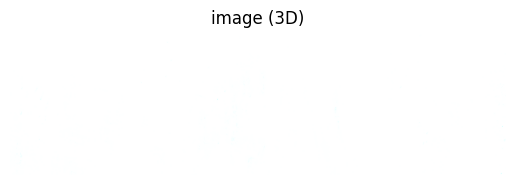

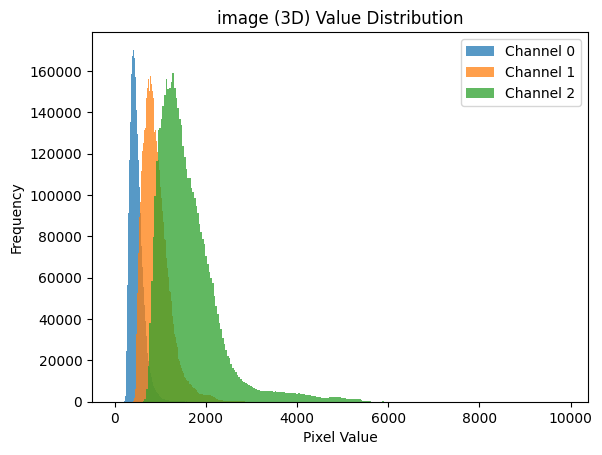

Key: image, Shape: (50, 1202, 4172)


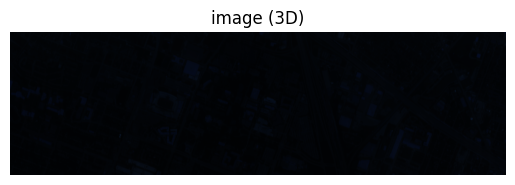

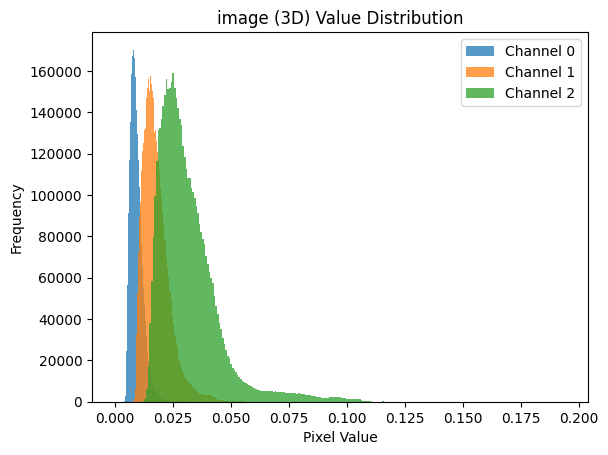

In [16]:

plot_mat_info(houstom_mat)
plot_mat_info(houston_normalied_mat)

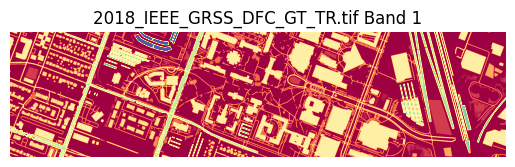

--------------------
FILE: 2018_IEEE_GRSS_DFC_GT_TR.tif
raster shape:   (1, 1202, 4768)


In [20]:
plot_geotiff(houston_tain_tif,1)
print_geotiff_info(houston_tain_tif)

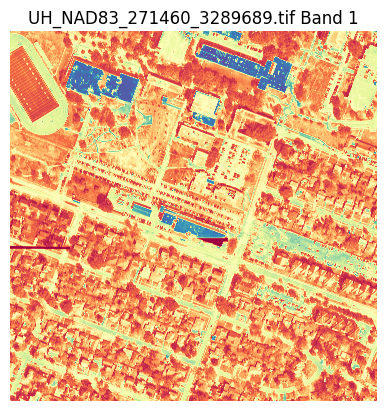

--------------------
FILE: UH_NAD83_271460_3289689.tif
raster shape:   (3, 12020, 11920)


In [22]:
plot_geotiff(houston_rgb_tif,1)
print_geotiff_info(houston_rgb_tif)

In [19]:
!bash train_houston.sh 4 0 1 HyperSIGMA houston

===>GPU: 0
cuda
Start seed:  3000
===> Loading datasets
train_path: ./dataset/houston_x4/trains/
test_data_dir: ./dataset/houston_x4/houston_test.mat
result_path: ./results/houston_x4/
-----------------
Traceback (most recent call last):
  File "/home/lofty/CODE/HyperSIGMA-fork/ImageSuperResolution/main38_houston.py", line 470, in <module>
    main()
  File "/home/lofty/CODE/HyperSIGMA-fork/ImageSuperResolution/main38_houston.py", line 108, in main
    train(args)
  File "/home/lofty/CODE/HyperSIGMA-fork/ImageSuperResolution/main38_houston.py", line 140, in train
    test_set = HSTestData(test_data_dir)
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lofty/CODE/HyperSIGMA-fork/ImageSuperResolution/data/HStest.py", line 11, in __init__
    self.ms = np.array(test_data['ms'][...], dtype=np.float32)
                       ~~~~~~~~~^^^^^^
KeyError: 'ms'
